[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239232-lesson-6-agent)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [35]:
from dotenv import load_dotenv

load_dotenv()

True

In [36]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

Let's create our LLM and prompt it with the overall desired agent behavior.

In [37]:
from pydantic import BaseModel, Field
class llm_response(BaseModel):
    row_number: int
    complain: str
    classify_complaint: str

In [111]:
import json
import pandas as pd
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama

# llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm = ChatOllama(model="aya-expanse", temperature=0)



In [137]:
def replace_turkish_chars(text):
  """
  Replaces Turkish characters with their closest English equivalents.

  Args:
      text: The text to be converted.

  Returns:
      The converted text with Turkish characters replaced.
  """
  char_map = {
    'İ':'i',
    'ı':'i',
    'ğ':'g',
    'Ğ':'g',
    'ö':'o',
    'Ö':'o',
    'ş':'s',
    'Ş':'s',
    'ç':'c',
    'Ç':'c',
    'ü':'u',
    'Ü':'u'
  }
  n = []
  for c in text:
      n.append(char_map.get(c, c))

  return ''.join(n)


In [138]:
replace_turkish_chars("SERTİFİKA AKTARIM").replace(" ", "").lower()

'sertifikaaktarim'

In [131]:
"SERTİFİKA AKTARIM".replace(" ", "").lower()

'serti̇fi̇kaaktarim'

In [150]:
class State(MessagesState):
    llm_class: str  = None
    llm_type: str = None

In [ ]:
complain_class_list = ['YENİLEME BAŞVURUSU',
 'ZAMAN DAMGASI',
 'SERTİFİKA AKTARIM',
 'TEKNİK DESTEK',
 'Kurulum Talebi',
 'WEB',
 'Sertifika İptal & Askı',
 'PIN-PUK BİLGİSİ - ŞİFRE BLOKESİ (Token )',
 'DİĞER',
 'KURULUM BİLGİSİ-PROGRAM YÜKLEME',
 'KARGO TAKİP BİLGİSİ',
 'KURUMSAL ÜRÜN SATINALMA-DESTEK TALEPLERİ',
#  'EBİMZA',
 'Müşteri Hizmetlerine Ulaşamama Sorunu',
 'PTT Hizmetinde Kimlik Doğrulama Sorunu Ve Uzun Bekleme Süresi',
 'FATURA–MUHASEBE',
 'PERSONEL HAKKINDA GÖRÜŞLER',
#  'YENİ BAŞVURU',
 'E-Güven Müşteri Hizmetlerinde Uzun Bekleme Süresi Sorunu',
 'PTT SÜREÇLERİ',
 'E-güven Müşteri Hizmetlerinde Uzun Bekleme Süresi']

type_list = ['İşlem', 'İstek', 'Diğer', 'Soru', 'Şikayet', 'Bilgi', 'Teşekkür']


# System message
classify_sys_msg = SystemMessage(content=f"classify digital signature services customer complain as one of the following complain_class_list : {complain_class_list}. Return only a json object with key 'class', values should be one of the complain_class_list, and strictly nothing else.")
type_sys_msg = SystemMessage(content=f"classify digital signature services customer complain type as one of the following type_list : {type_list}. Return only a json object with key 'type', values should be one of the type_list, and strictly nothing else.")

# Node
def class_assistant(state: State):
   return {"messages": [llm.invoke([classify_sys_msg] + state["messages"])]}

def type_assistant(state: State):
   return {"messages": [llm.invoke([type_sys_msg] + state["messages"])]}

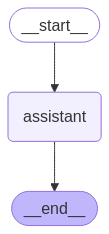

In [ ]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("classifier", class_assistant)
builder.add_node("tagifier", type_assistant)


# Define edges: these determine how the control flow moves
builder.add_edge(START, "classifier")
builder.add_edge("classifier", "tagifier")
builder.add_edge("tagifier", END)
graph = builder.compile()

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [141]:
def parse_response(response):
    try:
        start = response.find("{")
        end = response.rfind("}") + 1
        class_dict = json.loads(response[start:end])
    except:
        class_dict = {"class": "UNKNOWN"}
    return class_dict
    

In [147]:
def find_class(class_dict):
    llm_class = replace_turkish_chars(class_dict.get("class", "UNKNOWN")).replace(" ", "").lower()
    for complain_class in complain_class_list:
        if replace_turkish_chars(complain_class).replace(" ", "").lower() == llm_class:
            return complain_class
    print(f"PROPOSED: {class_dict.get('class', 'UNKNOWN')}")
    return f"PROPOSED: {class_dict.get('class', 'UNKNOWN')}" 


In [149]:
tickets = pd.read_excel('crm_subat.xlsx', parse_dates=['Datetime'])

# Process the tickets and write the output to a JSONL file
response_list = []
with open("tickets_output_new.jsonl", "w") as output_file:
    for index, row in tickets.iterrows():
        if pd.isna(row['Requirement']):
            response_list.append("UNKNOWN")
            continue  # Skip rows with missing 'Requirement'
        request_message = [HumanMessage(content=row['Requirement'])]
        response_message = graph.invoke({"messages": request_message})
        llm_class = response_message["messages"][-1].content
        class_dict = parse_response(llm_class)
        class_found = find_class(class_dict)
        response_list.append(class_found)
        print(f"Row Class : {row['Class']} -> LLM class: {class_found}")
        # if index > 4:
        #     break

tickets['llm_class'] = response_list
tickets.to_excel('crm_subat_output.xlsx', index=False)



/Users/mervesarac/Development/eguven/venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


Row Class : YENİLEME BAŞVURUSU -> LLM class: Müşteri Hizmetlerine Ulaşamama Sorunu
Row Class : ZAMAN DAMGASI -> LLM class: ZAMAN DAMGASI
Row Class : SERTİFİKA AKTARIM -> LLM class: SERTİFİKA AKTARIM
Row Class : TEKNİK DESTEK -> LLM class: ZAMAN DAMGASI
Row Class : Kurulum Talebi -> LLM class: Kurulum Talebi
Row Class : WEB -> LLM class: FATURA–MUHASEBE
Row Class : ZAMAN DAMGASI -> LLM class: ZAMAN DAMGASI
Row Class : WEB -> LLM class: TEKNİK DESTEK
Row Class : Sertifika İptal & Askı -> LLM class: Sertifika İptal & Askı
Row Class : YENİLEME BAŞVURUSU -> LLM class: YENİLEME BAŞVURUSU
Row Class : SERTİFİKA AKTARIM -> LLM class: PIN-PUK BİLGİSİ - ŞİFRE BLOKESİ (Token )
Row Class : SERTİFİKA AKTARIM -> LLM class: Sertifika İptal & Askı
Row Class : PIN-PUK BİLGİSİ - ŞİFRE BLOKESİ (Token ) -> LLM class: PIN-PUK BİLGİSİ - ŞİFRE BLOKESİ (Token )
Row Class : WEB -> LLM class: Sertifika İptal & Askı
Row Class : DİĞER -> LLM class: ZAMAN DAMGASI
PROPOSED: ÖDEME
Row Class : SERTİFİKA AKTARIM -> LLM

In [77]:
len(response_list), len(tickets)

(745, 746)